# Gather Data <a class="tocSkip">

In [1]:
%load_ext autoreload
%autoreload 2

In [119]:
import sys
import tweepy
import pickle
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
from tqdm import tqdm_notebook
from datetime import datetime as dt

sys.path.append('../bin')
import myutil
import dataset
from dataset import Holomem

prj_path = myutil.PROJECT_PATH
prj_path

PosixPath('/Users/nyu/gdrive/learn/hololi2vec')

<h1>目次<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Tweepyを触ってみる" data-toc-modified-id="Tweepyを触ってみる-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Tweepyを触ってみる</a></span><ul class="toc-item"><li><span><a href="#Hello-Tweepy!" data-toc-modified-id="Hello-Tweepy!-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Hello Tweepy!</a></span></li><li><span><a href="#特定ユーザのツイート取得" data-toc-modified-id="特定ユーザのツイート取得-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>特定ユーザのツイート取得</a></span></li></ul></li><li><span><a href="#Holomemクラス" data-toc-modified-id="Holomemクラス-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Holomemクラス</a></span><ul class="toc-item"><li><span><a href="#ホロライブメンバーデータ作成" data-toc-modified-id="ホロライブメンバーデータ作成-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>ホロライブメンバーデータ作成</a></span></li><li><span><a href="#インスタンス生成" data-toc-modified-id="インスタンス生成-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>インスタンス生成</a></span></li></ul></li><li><span><a href="#ホロメンツイートデータ収集" data-toc-modified-id="ホロメンツイートデータ収集-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>ホロメンツイートデータ収集</a></span><ul class="toc-item"><li><span><a href="#ツイート総数確認" data-toc-modified-id="ツイート総数確認-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>ツイート総数確認</a></span></li><li><span><a href="#ツイート収集" data-toc-modified-id="ツイート収集-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>ツイート収集</a></span></li><li><span><a href="#ツイートデータ収集方法再検討" data-toc-modified-id="ツイートデータ収集方法再検討-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>ツイートデータ収集方法再検討</a></span></li><li><span><a href="#APIの設定でRTを省かない場合の検証" data-toc-modified-id="APIの設定でRTを省かない場合の検証-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>APIの設定でRTを省かない場合の検証</a></span></li><li><span><a href="#ツイート再収集" data-toc-modified-id="ツイート再収集-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>ツイート再収集</a></span></li></ul></li></ul></div>

# Tweepyを触ってみる
- ツイートの出力結果はコミット時にすべて消去
- 参考: https://qiita.com/kitarikes/items/543ab75a379f0bf903cc
- 公式doc.: https://docs.tweepy.org/en/latest/index.html

## Hello Tweepy!
- `tweepy.API()`のオプションとして，`wait_on_rate_limit`と`wait_on_rate_limit_notify`をいずれも`True`にすることで，APIのレート制限をハンドリングできる
- 参考: https://compass-note.hatenablog.com/entry/twitter-api-tweepy-rate-limit

In [12]:
api_key, api_secret, access_token, access_secret = myutil.load_twitter_api_keys()

auth = tweepy.OAuthHandler(api_key, api_secret)
auth.set_access_token(access_token, access_secret)
api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

In [ ]:
public_tweets = api.home_timeline(count=3)
for tweet in public_tweets:
    print('-------------------------')
    print(tweet.user.name)
    print(tweet.text)

## 特定ユーザのツイート取得
- 公式doc. https://docs.tweepy.org/en/latest/api.html#API.user_timeline
- リプは**含める**が，RTは**含めない**

In [173]:
# シオンよ...
shion = 'murasakishionch'

シオンちゃんの最新1000ツイートを取得してみる

In [49]:
%%time
shion_tweets = [tweet for tweet in tweepy.Cursor(api.user_timeline, screen_name=shion, include_rts=False).items(1000)]

CPU times: user 977 ms, sys: 69.8 ms, total: 1.05 s
Wall time: 14 s


In [ ]:
for tweet in shion_tweets[:5]:
    print('-------------------------')
    print(tweet.created_at)
    print(tweet.text)

pkl形式で保存

In [133]:
with open(Path(prj_path, 'data/tweets_murasakishionch_1000.pkl'), mode='wb') as f:
    pickle.dump(shion_tweets, f)

In [134]:
type(shion_tweets[0])

tweepy.models.Status

ツイートデータからデータフレーム作成

In [135]:
with open(Path(prj_path, 'data/tweets_murasakishionch_1000.pkl'), mode='rb') as f:
    shion_tweets = pickle.load(f)

- データフレームにはツイートのユーザID(Twitter ID)，投稿日時，テキストのみ含める
- 基本的には以後の分析ではこの3つのデータのみ扱う

In [ ]:
shion_tweets_data = [[] for _ in range(1000)]
for idx, tweet in enumerate(shion_tweets):
    data = [tweet.user.screen_name, tweet.created_at, tweet.text]
    shion_tweets_data[idx] = data
    
shion_tweets_df = pd.DataFrame(shion_tweets_data, columns=['userId', 'timestamp', 'text'])
shion_tweets_df.head()

In [181]:
shion_tweets_df.dtypes

userId               object
timestamp    datetime64[ns]
text                 object
dtype: object

- tsv形式で保存
- ツイートにカンマが含まれていると面倒なため（一応`text`は最後の列なのでcsv形式でも影響はないが，もし今後順番を入れ替えたりなどして崩壊するのを避けるため）

In [182]:
shion_tweets_df_path = Path(prj_path, 'data/tweets_murasakishionch_1000.tsv')
shion_tweets_df.to_csv(shion_tweets_df_path, sep='\t', index=True)

In [ ]:
shion_tweets_df_ = pd.read_csv(shion_tweets_df_path, sep='\t')
shion_tweets_df.head()

# Holomemクラス
ホロライブメンバーのクラス`Holomen`を作って，ツイートデータなどをメンバーごとに管理する

## ホロライブメンバーデータ作成
- ホロライブタブのメンバーが対象: https://www.hololive.tv/member （ホロスタ・イノミュ・ID・ENに属するメンバー除く）
- 順番は上のサイトの掲載順（上から左から）
- 0期: 4人（すいちゃん含む） / 1期: 5人 / 2期: 5人 / ゲーマーズ: 4人（フブキング兼任） / 3期: 5人 / 4期: 5人 / 5期: 5人

In [4]:
hololive_members = pd.read_csv(Path(prj_path, 'data/hololive_members.csv'))
hololive_members

,twitter,name,generation
0,tokino_sora,ときのそら,0
1,robocosan,ロボ子さん,0
2,sakuramiko35,さくらみこ,0
3,suisei_hosimati,星街すいせい,0
4,yozoramel,夜空メル,1
5,shirakamifubuki,白上フブキ,1/gamers
6,natsuiromatsuri,夏色まつり,1
7,akaihaato,赤井はあと,1
8,akirosenthal,アキ・ローゼンタール,1
9,minatoaqua,湊あくあ,2


## インスタンス生成
- シオンちゃんを例に作る
- 取得ツイート数はとりあえず1000に設定

In [ ]:
shion_1000 = Holomem(userId='murasakishionch', n_tweet=1000, verbose=True, preview=True)

In [199]:
shion_1000.userId, shion_1000.name, shion_1000.generation

('murasakishionch', '紫咲シオン', {'2'})

In [ ]:
shion_1000.df.head()

# ホロメンツイートデータ収集

## ツイート総数確認
メンバーあたり過去何件分のツイートが取得できそうか，現時点の総ツイート数の全体的な傾向から判断する

In [5]:
holomem_all_twitter = hololive_members['twitter'].values
n_holomem = holomem_all_twitter.shape[0]

n_holomem, holomem_all_twitter

(31,
 array(['tokino_sora', 'robocosan', 'sakuramiko35', 'suisei_hosimati',
        'yozoramel', 'shirakamifubuki', 'natsuiromatsuri', 'akaihaato',
        'akirosenthal', 'minatoaqua', 'nakiriayame', 'yuzukichococh',
        'murasakishionch', 'oozorasubaru', 'ookamimio', 'nekomataokayu',
        'inugamikorone', 'shiranuiflare', 'shiroganenoel', 'houshoumarine',
        'usadapekora', 'uruharushia', 'amanekanatach', 'kiryucoco',
        'tsunomakiwatame', 'tokoyamitowa', 'himemoriluna', 'yukihanalamy',
        'momosuzunene', 'shishirobotan', 'omarupolka'], dtype=object))

In [213]:
%%time
holomem_all_sum_tweet = np.zeros(n_holomem, dtype=int)
for idx, userId in enumerate(holomem_all_twitter):
    holomem_all_sum_tweet[idx] = api.get_user(screen_name=userId).statuses_count
    
holomem_all_sum_tweet

CPU times: user 427 ms, sys: 24.4 ms, total: 452 ms
Wall time: 5.46 s


array([21999, 40475, 31488, 11365, 16145, 80418, 39645, 17940, 34840,
       13619, 11305, 21698, 13918, 16438, 11236, 11764, 15300, 16433,
        8046, 15097,  9083, 13952,  7839,  8574, 12926,  7105,  3942,
       10271,  3637,  6572,  5351])

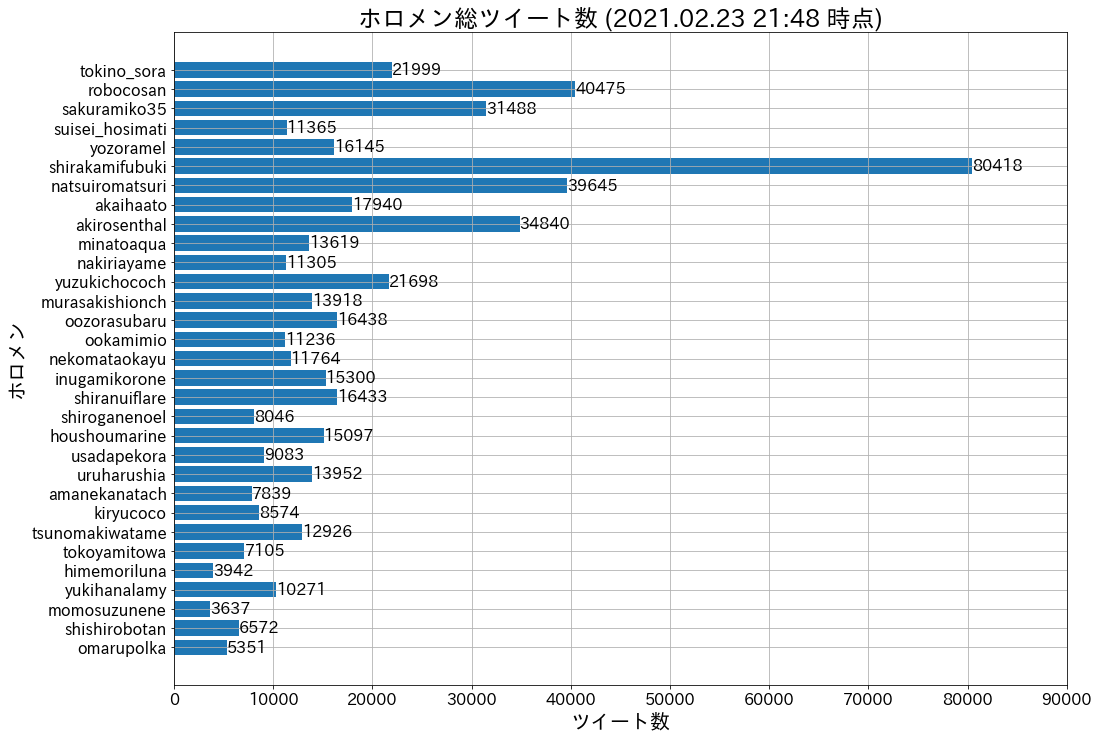

In [267]:
holomem_idx = np.arange(n_holomem)[::-1]

fig, ax = plt.subplots(figsize=(16, 12))
ax.set_title('ホロメン総ツイート数 ({})'.format(dt.now().strftime('%Y.%m.%d %H:%M 時点')), size=24)
rect = ax.barh(np.arange(n_holomem), holomem_all_sum_tweet[::-1])

ax.set_xlabel('ツイート数', size=20)
ax.tick_params(axis='x', labelsize=16)

ax.set_ylabel('ホロメン', size=20)
ax.set_yticks(holomem_idx)
ax.set_yticklabels(holomem_all_twitter, size=16)
ax.grid()
ax.set_xlim(xmax=90000)

for x, y in zip(holomem_all_sum_tweet[::-1], holomem_idx[::-1]):
    ax.text(x, y, x, ha='left', va='center', size=16)

fig.savefig(Path(prj_path, 'result/01_Gather_Data/holomem_tweet_sum.png'), bbox_inches='tight', pad_inches=0)

- ホロメンは告知やイラストなどRTが多いことが予想され，実際に自身で送信しているツイート（リプ含む）は半分ぐらいであることが考えられる
- 各メンバーのツイートを1/2にして考えると，5期の一部メンバーを除いて約4000件は各メンバー取得できそう
- 各メンバーに対し，過去4000件のツイート（RT除く）を取得する方針に決定
- もし不足する場合は上限数までの取得に留める

## ツイート収集

In [270]:
n_holomem, holomem_all_twitter

(31,
 array(['tokino_sora', 'robocosan', 'sakuramiko35', 'suisei_hosimati',
        'yozoramel', 'shirakamifubuki', 'natsuiromatsuri', 'akaihaato',
        'akirosenthal', 'minatoaqua', 'nakiriayame', 'yuzukichococh',
        'murasakishionch', 'oozorasubaru', 'ookamimio', 'nekomataokayu',
        'inugamikorone', 'shiranuiflare', 'shiroganenoel', 'houshoumarine',
        'usadapekora', 'uruharushia', 'amanekanatach', 'kiryucoco',
        'tsunomakiwatame', 'tokoyamitowa', 'himemoriluna', 'yukihanalamy',
        'momosuzunene', 'shishirobotan', 'omarupolka'], dtype=object))

2021年2月23日22:10頃(JST)より取得開始

In [275]:
%%time
for userId in tqdm_notebook(holomem_all_twitter):
    Holomem(userId=userId, n_tweet=4000, load=False, verbose=True, preview=False)

<timed exec>:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/31 [00:00<?, ?it/s]

[myutil] 以下パスにツイートデータを保存しました
[myutil] /Users/nyu/gdrive/learn/hololi2vec/data/tweets_tokino_sora_4000.pkl
[myutil] 以下パスにツイートデータを保存しました
[myutil] /Users/nyu/gdrive/learn/hololi2vec/data/tweets_robocosan_4000.pkl
[myutil] 以下パスにツイートデータを保存しました
[myutil] /Users/nyu/gdrive/learn/hololi2vec/data/tweets_sakuramiko35_4000.pkl
[myutil] 以下パスにツイートデータを保存しました
[myutil] /Users/nyu/gdrive/learn/hololi2vec/data/tweets_suisei_hosimati_4000.pkl
[myutil] 以下パスにツイートデータを保存しました
[myutil] /Users/nyu/gdrive/learn/hololi2vec/data/tweets_yozoramel_4000.pkl
[myutil] 以下パスにツイートデータを保存しました
[myutil] /Users/nyu/gdrive/learn/hololi2vec/data/tweets_shirakamifubuki_4000.pkl
[myutil] Rate limit reached. Sleeping for: 302
[myutil] 以下パスにツイートデータを保存しました
[myutil] /Users/nyu/gdrive/learn/hololi2vec/data/tweets_natsuiromatsuri_4000.pkl
[myutil] 以下パスにツイートデータを保存しました
[myutil] /Users/nyu/gdrive/learn/hololi2vec/data/tweets_akaihaato_4000.pkl
[myutil] 以下パスにツイートデータを保存しました
[myutil] /Users/nyu/gdrive/learn/hololi2vec/data/tweets_akirosenthal_

CPU times: user 1min 22s, sys: 6.07 s, total: 1min 28s
Wall time: 1h 11min 22s


各ホロメンの取得できたツイート数を確認する

In [6]:
for userId in tqdm_notebook(holomem_all_twitter):
    holomem = Holomem(userId=userId, n_tweet=4000, load=True, verbose=False, preview=False)
    print(holomem.userId, len(holomem.df))

<ipython-input-6-f478b14151cb>:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for userId in tqdm_notebook(holomem_all_twitter):


  0%|          | 0/31 [00:00<?, ?it/s]

tokino_sora 2627
robocosan 1855
sakuramiko35 1862
suisei_hosimati 2222
yozoramel 366
shirakamifubuki 2331
natsuiromatsuri 2114
akaihaato 2731
akirosenthal 1963
minatoaqua 2144
nakiriayame 2211
yuzukichococh 2256
murasakishionch 2659
oozorasubaru 2123
ookamimio 1544
nekomataokayu 1278
inugamikorone 1746
shiranuiflare 1831
shiroganenoel 2249
houshoumarine 1598
usadapekora 2022
uruharushia 2285
amanekanatach 1938
kiryucoco 1636
tsunomakiwatame 1738
tokoyamitowa 2178
himemoriluna 2184
yukihanalamy 2403
momosuzunene 2273
shishirobotan 1886
omarupolka 1533


- 4000件取得できたホロメンは1人もいない
- 総ツイート数に関係なく取得数の差が極端で，メルちゃん(`yorozamel`)は366/16145件しか取れておらず，ねねちゃん(`momosuzunene`)は2272/3637件も取得に成功している
- 可能な限り多くのツイートを取得できる収集方法の再検討を行う

## ツイートデータ収集方法再検討

- [公式ドキュメント](https://developer.twitter.com/en/docs/twitter-api/tweets/timelines/introduction)を参照したところ，1人のユーザに対して取得できるツイートは最新3200ツイートであることが判明
- 過去記事で3200ツイート以上取得しようとしているケースがあったが，仕様変更前 or 実は3200しか取れてない？（制限より多い数の取得数を指定してもエラーは吐かない）

再検討のため...
- 極端に少ないメルちゃんのデータで色々検証する
- 4000ではなく3200ツイートを取得する設定で試す

In [45]:
mel = Holomem(userId='yozoramel', n_tweet=3200, load=False, verbose=True, preview=False)

[hololi2vec:myutil] 以下パスにツイートデータを保存しました
[hololi2vec:myutil] /Users/nyu/gdrive/learn/hololi2vec/data/tweets_yozoramel_3200.pkl


In [46]:
len(mel.df)

371

- なぜか4000指定より5件増えた(366->371)が，非常に少ないことには変わりない
- データ末尾を確認する

In [ ]:
mel.df.tail()

- 2020.12.07までのツイートしか取得できていない
- メルちゃんが2020.12.07から現在まで他の期間と比較して極端に多くのツイートをしていたわけではない
- ↑あとで調べたところ，776/16145件だった

仮方針
- 取得の仕方に問題があるのではないかと考え，`tweepy.Cursor().items()`ではなく，ページごとに取得する方法で試す
- 以下は1ページ200件ずつで計16ページ取得している．恐らく3200ツイートになるはず...

In [60]:
mel_tweets_pages_c200 = []
for page in range(1, 17):
    mel_tweets = api.user_timeline(screen_name='yozoramel', count=200, include_rts=False, page=page)
    print('{}: {}'.format(page, len(mel_tweets)))
    mel_tweets_pages_c200.extend(mel_tweets)

1: 155
2: 98
3: 0
4: 0
5: 0
6: 0
7: 0
8: 0
9: 0
10: 0
11: 0
12: 0
13: 0
14: 0
15: 0
16: 0


- 3ページ目以降なぜか全くツイートを取得できていない
- 1,2ページでも200件に達していない
- 取得できたツイート数の合計は252

In [61]:
len(mel_tweets_pages_c200)

253

In [ ]:
for tweet in mel_tweets_pages_c200[-5:]:
    print(tweet.created_at)
    print(tweet.text)

- 2020.12.20までのツイートしか取得できていない
- 今度は1ページ100件ずつ，32ページで試す

In [51]:
mel_tweets_pages_c100 = []
for page in range(1, 33):
    mel_tweets = api.user_timeline(screen_name='yozoramel', count=100, include_rts=False, page=page)
    print('{}: {}'.format(page, len(mel_tweets)))
    mel_tweets_pages_c100.extend(mel_tweets)

len(mel_tweets_pages_c100)

1: 80
2: 55
3: 13
4: 0
5: 0
6: 0
7: 0
8: 0
9: 0
10: 0
11: 0
12: 0
13: 0
14: 0
15: 0
16: 0
17: 0
18: 0
19: 0
20: 0
21: 0
22: 0
23: 0
24: 0
25: 0
26: 0
27: 0
28: 0
29: 0
30: 0
31: 0
32: 0


148

- より悪化しており，4ページ目以降取得できていない
- 合計148ツイート
- 2020.01.05までのツイートしか取得できていない

In [ ]:
for tweet in mel_tweets_pages_c100[-5:]:
    print(tweet.created_at)
    print(tweet.text)

- [調べると](https://stackoverflow.com/questions/28113266/tweepy-include-rts-not-working)，`user_timeline()`のオプション`include_rts = True`は先に`count`数分取得したあとにRTを削除する仕様であることが判明
- その仕様がわかっても，200件ずつ取得しようとする際に3ページ目以降の取得ツイートがゼロになる理由がわからない...
- もしかしたら1ページ目で`include_rts = True`で除外されたツイートが2ページ目でまた取得されて...という流れが以後続いて，3ページ目以降取得できるツイートがRTだけになってしまっているのではないか（RTが繰り越されるために取得ツイートが単調減少）
- メルちゃんは他のホロメンに比べRTが多い傾向なので，`include_rts = True`と設定したことが，取得数が極端に少なくなった原因である可能性が高い

## APIの設定でRTを省かない場合の検証

- `include_rts = False`にして，一旦ツイートを取得して保持し，Tweepy外でRTを省けばよいと考える
- 以下はその検証で，RTが省かれる前と後のツイート数の変動を各ページごとに示している

In [63]:
mel_tweets_pages_c200_hand = []
for page in range(1, 17):
    mel_tweets = api.user_timeline(screen_name='yozoramel', count=200, page=page)
    mel_tweets_filtered = [tweet for tweet in mel_tweets if tweet.text[:2] != 'RT']
    print('{}: {} -> {}'.format(page, len(mel_tweets), len(mel_tweets_filtered)))
    mel_tweets_pages_c200_hand.extend(mel_tweets_filtered)
    
len(mel_tweets_pages_c200_hand)

1: 200 -> 155
2: 199 -> 143
3: 200 -> 73
4: 199 -> 8
5: 200 -> 133
6: 200 -> 193
7: 200 -> 106
8: 198 -> 97
9: 200 -> 155
10: 199 -> 156
11: 200 -> 163
12: 200 -> 173
13: 200 -> 193
14: 200 -> 198
15: 200 -> 186
16: 199 -> 118


2250

- RT除外後，2250件も取得できた
- 16ページまでほぼ200件取得できている
- たまに何らかのエラーで198or199件しか取得できていないが，それほど気にすることでもないので，この原因は深く追究しない

先に述べた
```
1ページ目で`include_rts = True`で除外されたツイートが2ページ目でまた取得されて...という処理が以後続いて，3ページ目以降取得できるツイートがRTだけにな全て除外されれしまっているのではないか
```
という仮定だが，

```
`include_rts=True`
- 1: 155
- 2: 98
- 3: 0
- 4: 0

`include_rts=False`
- 1: 200 -> 155
- 2: 199 -> 143
- 3: 200 -> 73
- 4: 199 -> 8
```
のように，1ページ目の取得ツイート数が一致しており，以後の推移を比較してみると，なんとなく正しい予感がする．

このプロジェクトの内容からあまり外れる内容なのでこれ以上深く追求しないが，また別に詳しく検証したい

In [ ]:
for tweet in mel_tweets_pages_c200_hand[-5:]:
    print(tweet.created_at)
    print(tweet.text)

 RTを手動（Tweepy外）で省く場合，6月末のツイートまで取得できていた

- `include_rts`の設定が原因で，取得の方法自体には問題なさそうなので，当初の`Cursor(api.user_timeline).items()`を使った場合でも確認する
- ページ取得の場合と同様に`include_rts=True`に変更しているだけ

In [66]:
mel_tweets_pages_cursor_rt = [
    tweet for tweet in tweepy.Cursor(api.user_timeline, screen_name='yozoramel', include_rts=True).items(3200)]
len(mel_tweets_pages_cursor_rt)

3200

RTを手動で省く前の取得数について，ページを使った200件ずつの取得の場合3194件しか取得できなかったが，`Cursor(api.user_timeline).items()`の場合は，3200ツイートぴったり取得できた

In [ ]:
for tweet in mel_tweets_pages_cursor_rt[-5:]:
    print(tweet.created_at)
    print(tweet.text)

- 末尾ツイート投稿時刻
    - ページ取得: 2020-06-27 23:55:19
    - `Cursor(api.user_timeline).items()`: 2020-06-27 23:53:59
- 後者の方が若干古いツイートまで取得できている

**結論**
- `Cursor(api.user_timeline).items(3200)`で3200ツイート取得し，RTを手動で(Tweepy外)で除外する方針をとる
- RT除外はこのノートブックでは扱わず，次の`02_Format_Data`で行うことにする

## ツイート再収集

- 上記方針に合わせ，`dataset.Holomen.get_tweets()`のコードを修正済み
- 2021年2月24日22:31(JST)より取得開始

In [68]:
%%time
for userId in tqdm_notebook(holomem_all_twitter):
    Holomem(userId=userId, n_tweet=3200, load=False, verbose=True, preview=False)

<timed exec>:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/31 [00:00<?, ?it/s]

[hololi2vec:myutil] 以下パスにツイートデータを保存しました
[hololi2vec:myutil] /Users/nyu/gdrive/learn/hololi2vec/data/tweets_tokino_sora_3200.pkl
[hololi2vec:myutil] 以下パスにツイートデータを保存しました
[hololi2vec:myutil] /Users/nyu/gdrive/learn/hololi2vec/data/tweets_robocosan_3200.pkl
[hololi2vec:myutil] 以下パスにツイートデータを保存しました
[hololi2vec:myutil] /Users/nyu/gdrive/learn/hololi2vec/data/tweets_sakuramiko35_3200.pkl
[hololi2vec:myutil] 以下パスにツイートデータを保存しました
[hololi2vec:myutil] /Users/nyu/gdrive/learn/hololi2vec/data/tweets_suisei_hosimati_3200.pkl
[hololi2vec:myutil] 以下パスにツイートデータを保存しました
[hololi2vec:myutil] /Users/nyu/gdrive/learn/hololi2vec/data/tweets_yozoramel_3200.pkl
[hololi2vec:myutil] Rate limit reached. Sleeping for: 659
[hololi2vec:myutil] 以下パスにツイートデータを保存しました
[hololi2vec:myutil] /Users/nyu/gdrive/learn/hololi2vec/data/tweets_shirakamifubuki_3200.pkl
[hololi2vec:myutil] 以下パスにツイートデータを保存しました
[hololi2vec:myutil] /Users/nyu/gdrive/learn/hololi2vec/data/tweets_natsuiromatsuri_3200.pkl
[hololi2vec:myutil] 以下パスにツイートデータを保存しま

CPU times: user 1min 38s, sys: 9.08 s, total: 1min 47s
Wall time: 1h 17min 39s


In [109]:
for userId in tqdm_notebook(holomem_all_twitter):
    holomem = Holomem(userId=userId, n_tweet=3200, load=True, verbose=False, preview=False)
    print(holomem.userId, len(holomem.df))

<ipython-input-109-008f6bc16104>:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for userId in tqdm_notebook(holomem_all_twitter):


  0%|          | 0/31 [00:00<?, ?it/s]

tokino_sora 3200
robocosan 3200
sakuramiko35 3200
suisei_hosimati 3200
yozoramel 3200
shirakamifubuki 3200
natsuiromatsuri 3200
akaihaato 3200
akirosenthal 3200
minatoaqua 3200
nakiriayame 3200
yuzukichococh 3200
murasakishionch 3200
oozorasubaru 3200
ookamimio 3200
nekomataokayu 3200
inugamikorone 3200
shiranuiflare 3200
shiroganenoel 3195
houshoumarine 3200
usadapekora 3198
uruharushia 3200
amanekanatach 3200
kiryucoco 3200
tsunomakiwatame 3200
tokoyamitowa 3200
himemoriluna 3200
yukihanalamy 3200
momosuzunene 3193
shishirobotan 3200
omarupolka 3200


- 一部ホロメン除き，ほとんど3200ツイート取得できている（何らかのエラーで抜けがあるが，軽微な問題なので追求しない）
- RTは含まれた状態なので後のプロセスで省く

ホロメンクラスのインスタンスの例として，シオンちゃんを示す

In [ ]:
shion_3200 = Holomem(userId='murasakishionch', n_tweet=3200, load=True, verbose=False, preview=False)
shion_3200.df.head()

In [ ]:
shion_3200.df.tail()

- 取得状況に問題はないと考える
- 絵文字，顔文字，ハッシュタグ，リプライ先，リンクなど各ツイートの整形は大変そう...